# Differentiable Physics VII: Incompressible Navier Stokes

## Navier Stokes Equations

We limit the scope of the solver with the following constraints:

- We use the conservative form of the equations, meaning we are looking at a volume which is fixed in space and the fluid is moving through it.
- We use a 2D grid based approach, where each cell in the grid represents a volume element and has size $\Delta x \times \Delta y$.
- The fluid is incompressible. This means that the density $\rho$ is constant across the grid.

The following quantities are defined on the grid:

- $V$ : velocity vector field. $V = \begin{pmatrix} u \\ v \end{pmatrix}$
- $p_{i,j}$ : pressure scalar field
- $\rho$ : density, constant across the grid
- $\nu$: kinematic viscosity, constant across the grid
- $\tau_{i,j}$ : dye concentration vector field ( for visualization purposes )

The equations for the incompressible Navier Stokes equations are:

1. Momentum conservation:
$$\frac{\partial V}{\partial t} + V \cdot \nabla U= -\frac{1}{\rho} \nabla p + \nu \Delta U$$

2. Incompressibility or mass conservation:
$$\nabla \cdot V = 0$$

As we are interested in the 2D case, we can write the equations as:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \tag{1}$$

$$\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \tag{2}$$

In the incompressible case the momentum conservation equation and the incompressibility equation are not coupled. We can couple them by taking the divergence of the momentum conservation equation and applying the incompressibility property:

$$\nabla \left(\frac{\partial V}{\partial t} + V \cdot \nabla V\right) = \nabla \left( -\frac{1}{\rho} \nabla p + \nu \Delta V  \right)$$

On the LHS the term $\nabla \cdot \vec{v}$ is zero, so we get:


$$\nabla \left(V \cdot \nabla V\right) = \nabla \left( -\frac{1}{\rho} \nabla p + \nu \Delta V \right)$$

On the RHS $\nabla \nu \nabla^2 \vec{v}$ is zero, so we get:

$$\nabla \left(V \cdot \nabla V\right) = \nabla \left( -\frac{1}{\rho} \nabla p \right) = -\frac{1}{\rho} \Delta p$$

Which we can rearange to:

$$\Delta p = -\rho \nabla \left(V \cdot \nabla V\right)$$

Which can be written in 2D as:

$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = -\rho \left(  \frac{\partial u}{\partial x} \frac{\partial u}{\partial x} + 2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x} + \frac{\partial v}{\partial y} \frac{\partial v}{\partial y} \right) \tag{3}$$


Solvers for the Navier Stokes equations are usually based on the **projection method**. We use the Chorin projection method, which is a semi-implicit method. The method is based on the following steps:

1. Solve the momentum conservation equation for the intermediate velocity field $V^*$, ignoring the pressure term:

$$\frac{\partial V^*}{\partial t} + V \cdot \nabla V^* = \nu \Delta V^* \tag{4}$$

2. Solve the Poisson equation for the pressure field $p$:

$$\Delta p^{n+1} = -\rho \nabla \left(V^* \cdot \nabla V^* \right) \tag{5}$$

3. Correct the intermediate velocity field with the pressure field:

$$V^{n+1} = V^* - \frac{1}{\rho} \nabla p^{n+1} \tag{6}$$

The projection method is a semi-implicit method, because the momentum conservation equation is solved explicitly, while the Poisson equation is solved implicitly.

We use the Mac Cormack method to solve the momentum conservation equation which we have already seen in the previous notebook. To solve the Poisson equation we use the Jacobi method, which is a simple iterative method. There are more advanced methods for solving the Poisson equation, but the Jacobi method is simple and easy to implement.

## Solve for the intermediate velocity field $V^*$

To solve for the intermediate velocity field $V^*$ we use the MacCormack method as follows:

$$\bar{V}_{i,j}^{n+1, *} = V_{i,j}^n - \frac{\Delta t}{\Delta x} \left( E_{i+1, j}^{n} - E_{i, j}^{n} \right) - \frac{\Delta t}{\Delta y} \left( F_{i, j+1}^{n} - F_{i, j}^{n} \right)$$


and the corrector step as:


$$V_{i,j}^{n+1, *} = \frac{1}{2} \left[ \left( V_{i,j}^* + \bar{V}_{i,j}^{n+1,*} \right) - \frac{\Delta t}{ \Delta x} \left( \bar{E}_{i, j}^{n+1} - \bar{E}_{i-1, j}^{n+1} \right) - \frac{\Delta t}{\Delta y} \left( \bar{F}_{i, j}^{n+1} - \bar{F}_{i, j-1}^{n+1} \right) \right]$$

where we define the fluxes as:

$$E = \begin{bmatrix} u\cdot u + \nu \frac{\partial u}{\partial x} \\  u\cdot v + \nu \frac{\partial u}{\partial x}  \end{bmatrix} \quad F = \begin{bmatrix} u\cdot v + \nu \frac{\partial v}{\partial x} \\  v\cdot v + \nu \frac{\partial v}{\partial y}  \end{bmatrix}$$

the velocity $V$ and state vector $U$ as:

$$V = \begin{bmatrix} u \\ v \end{bmatrix} \quad U = \begin{bmatrix} u \\ v \\ p \end{bmatrix}$$


First order derivatives numerical approximations:

In [56]:
import jax.numpy as jnp
from jax import jit
from functools import partial

@partial(jit, static_argnames=("delta", "axis"))
def fd(f : jnp.ndarray, delta : float, axis : int):
    return jnp.roll(f, -1, axis=axis) - f / delta

@partial(jit, static_argnames=("delta", "axis"))
def bd(f : jnp.ndarray, delta : float, axis : int):
    return f - jnp.roll(f, 1, axis=axis) / delta

@partial(jit, static_argnames=("delta", "axis"))
def cd(f : jnp.ndarray, delta : float, axis : int):
    return (jnp.roll(f, -1, axis=axis) - jnp.roll(f, 1, axis=0)) / (2*delta)


Second order derivatives numerical approximations:

In [57]:
@partial(jit, static_argnames=("delta", "axis"))
def fd2(f : jnp.ndarray, delta : float, axis : int):
    return (jnp.roll(f, -1, axis=axis) - 2*f + jnp.roll(f, 1, axis=axis)) / delta**2

@partial(jit, static_argnames=("delta", "axis"))
def bd2(f : jnp.ndarray, delta : float, axis : int):
    return (jnp.roll(f, -1, axis=axis) - 2*f + jnp.roll(f, 1, axis=axis)) / delta**2

@partial(jit, static_argnames=("delta", "axis"))
def cd2(f : jnp.ndarray, delta : float, axis : int):
    return (jnp.roll(f, -1, axis=axis) - 2*f + jnp.roll(f, 1, axis=axis)) / delta**2

In [58]:
@partial(jit, static_argnames=("deltaA", "deltaB", "axisA", "axisB"))
def cdm(f : jnp.ndarray, deltaA : float, deltaB : float, axisA : int, axisB : int):
    return cd(cd(f, deltaA, axisA), deltaB, axisB)

Mixed second order derivatives numerical approximations:

In [59]:
from jax.tree_util import Partial

@partial(jit, static_argnames=("dx", "dy", "nu"))
def construct_E_F(
        V : jnp.ndarray, # Velocity field
        dx : float, 
        dy : float, 
        nu : float
    ) -> tuple[jnp.ndarray, jnp.ndarray]:
    
    u = V[..., 0]
    v = V[..., 1]

    E = jnp.zeros_like(V)
    F = jnp.zeros_like(V)

    E = E.at[..., 0].set(u * u + nu * cd(u, dx, 0))
    E = E.at[..., 1].set(u * v + nu * cd(u, dy, 1))

    F = F.at[..., 0].set(u * v + nu * cd(v, dx, 0))
    F = F.at[..., 1].set(v * v + nu * cd(v, dy, 1))

    return E, F

In [60]:
@partial(jit, static_argnames=("dt", "dx", "dy", "nu"))
def mac_cormack_2d(
        V : jnp.ndarray, # velocity field
        dt : float, # delta time
        dx : float, # delta x
        dy : float, # delta y
        nu : float, # viscosity
    ) -> jnp.ndarray:

    E, F = construct_E_F(V, dx, dy, nu)

    V_pred = V - \
        dt * cd(E, dx, 0) - \
        dt * cd(F, dy, 1)	

    E_pred, F_pred = construct_E_F(V_pred, dx, dy, nu)

    V_fwd = 1/2 * ( (V + V_pred) - \
        dt * cd(E_pred, dx, 0) - \
        dt * cd(F_pred, dy, 1) )
        
    return V_fwd

## Solve the Poisson equation for the pressure field $p$

Remember that the Poisson equation for the pressure field $p$ in 2D is:

$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = f$$

where we define $f$ as:

$$ f = -\rho \left(  \frac{\partial u}{\partial x} \frac{\partial u}{\partial x} + 2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x} + \frac{\partial v}{\partial y} \frac{\partial v}{\partial y} \right) $$


We can discretize the Poisson equation as follows:

$$\frac{p_{i+1, j} - 2 p_{i,j} + p_{i-1,j}}{\Delta x^2} + \frac{p_{i, j+1} - 2 p_{i,j} + p_{i,j-1}}{\Delta y^2} = f$$

under the assumption that $\Delta x = \Delta y$ we get:

$$ p_{i+1, j} - 2 p_{i,j} + p_{i-1,j} + p_{i, j+1} - 2 p_{i,j} + p_{i,j-1} = f \Delta x^2$$

which we can rearrange to:

$$ p_{i,j} = \frac{1}{4} \left( p_{i+1, j} + p_{i-1,j} + p_{i, j+1} + p_{i,j-1} - f \Delta x^2 \right)$$

which can be used to iteratively solve for $p_{i,j}$.

**Question: is this the jacobi method?**



In [117]:
from jax.lax import fori_loop

@partial(jit, static_argnames=("dx", "dy"))
def jacobi_step(
        p : jnp.ndarray, # pressure field
        f : jnp.ndarray, # RHS
        dx : float, 
        dy : float
    ) -> jnp.ndarray:
    
    p_new = jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0) + \
        jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1) - \
        dx**2 * f

    return p_new / 4

@partial(jit, static_argnames=("dx", "dy", "iterations"))
def jacobi(
        p_0 : jnp.ndarray, 
        f : jnp.ndarray, 
        dx : float, 
        dy : float, 
        iterations : int
    ) -> jnp.ndarray:

    assert dx == dy

    body_fun = lambda i, p_i: jacobi_step(p_i, f, dx, dy)

    p_n = fori_loop(0, iterations, body_fun, p_0)
    
    return p_n

## Simulation

In [130]:
@partial(jit, static_argnames=("dt", "dx", "dy", "nu", "rho", "iterations"))
def ns_solver_step(
    U : jnp.ndarray, # state vector
    dt : float, # time step
    dx : float, # grid spacing x
    dy : float, # grid spacing y
    nu : float, # viscosity
    rho : float, # density
    iterations : int # number of iterations for jacobi solver
) -> jnp.ndarray:
    
    V = U[..., :2]
    u = V[..., 0]
    v = V[..., 1]
    p = U[..., 2]
    
    # predict velocity
    V_star = mac_cormack_2d(V, dt, dx, dy, nu)

    # compyte RHS for pressure
    f = cd(u, dx, 0) ** 2 + \
        cd(v, dy, 1) ** 2 + \
        cd(u, dx, 0) * cd(v, dy, 1)
    
    # solve for pressure
    p_fwd = jacobi(p, f, dx, dy, iterations)
    grad_p = jnp.stack((cd(p_fwd, dx, 0), cd(p_fwd, dy, 1)), axis=-1)

    # correct velocity
    V_fwd = V_star - grad_p / rho

    U_fwd = jnp.zeros_like(U)
    U_fwd = U_fwd.at[..., :2].set(V_fwd)
    U_fwd = U_fwd.at[..., 2].set(p_fwd)
    
    return U_fwd

@partial(jit, static_argnames=("dt", "dx", "dy", "nu", "solver_iterations", "steps"))
def ns_solver(
        U_0 : jnp.ndarray, # state vector
        dt : float, # time step
        dx : float, # grid spacing x
        dy : float, # grid spacing y
        nu : float, # viscosity
        rho : float, # density
        solver_iterations : int, # number of iterations for jacobi solver
        steps : int, # number of steps
    ) -> jnp.ndarray:

    body_fun = lambda i, U_i: ns_solver_step(U_i, dt, dx, dy, nu, rho, solver_iterations)
    U_n = fori_loop(0, steps, body_fun, U_0)

    return U_n

In [167]:
dx = 0.1
dy = 0.1
dt = 0.01

nu = 0.1
rho = 1.0

nx = 100
ny = 100

x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)

X, Y = jnp.meshgrid(x, y, indexing="ij")

U = jnp.zeros((nx, ny, 3), dtype=jnp.float32)
# set pressure to 1
U = U.at[..., 2].set(1.0)
# set velocity to 1 in x direction
U = U.at[20, ny//4 : ny//4*3, 0].set(0.2)

jacobi_steps = 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


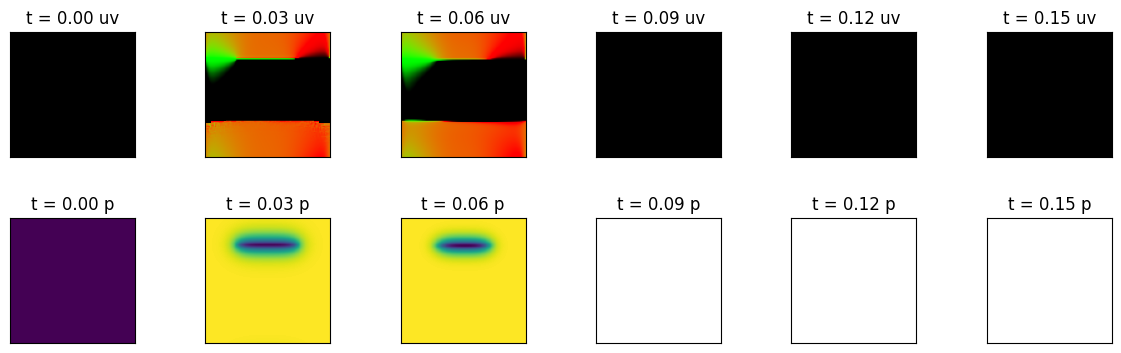

In [168]:
import matplotlib.pyplot as plt

total_time_steps = 18
n_views = 6
fig, axs = plt.subplots(2, n_views, figsize=(n_views * 2, 4))
fig.tight_layout( pad=2.0)

for i in range(n_views):
    uv0 = jnp.stack((U[..., 0], U[..., 1], jnp.zeros_like(U[..., 0])), axis=-1)
    # normalize
    uv0 = uv0 / jnp.linalg.norm(uv0, axis=-1, keepdims=True)
    axs[0, i].imshow(uv0)
    axs[0, i].set_title(f"t = {i * total_time_steps // n_views * dt:.2f} uv")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])

    axs[1, i].imshow(U[..., 2])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].set_title(f"t = {i * total_time_steps // n_views * dt:.2f} p")

    U = ns_solver(U, dt, dx, dy, nu, rho, jacobi_steps, total_time_steps // n_views)
